In [ ]:
!pip install torch torchvision
!pip install kaggle


In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the CelebA dataset
!kaggle datasets download -d jessicali9530/celeba-dataset
!unzip celeba-dataset.zip -d celeba


Streaming output truncated to the last 5000 lines.
  inflating: celeba/img_align_celeba/img_align_celeba/197605.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197606.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197607.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197608.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197609.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197610.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197611.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197612.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197613.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197614.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197615.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197616.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197617.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197618.jpg  
  inflating

Starting Training Loop...
[0/5][0/1583] Loss_D: 1.5546 Loss_G: 5.6176 D(x): 0.5868 D(G(z)): 0.5501 / 0.0060
[0/5][50/1583] Loss_D: 0.1750 Loss_G: 9.2846 D(x): 0.9519 D(G(z)): 0.0715 / 0.0002
[0/5][100/1583] Loss_D: 0.8183 Loss_G: 12.4918 D(x): 0.9384 D(G(z)): 0.4025 / 0.0002
[0/5][150/1583] Loss_D: 1.0860 Loss_G: 9.1321 D(x): 0.9636 D(G(z)): 0.5842 / 0.0003
[0/5][200/1583] Loss_D: 2.2263 Loss_G: 4.1211 D(x): 0.3063 D(G(z)): 0.0048 / 0.0420
[0/5][250/1583] Loss_D: 0.4919 Loss_G: 4.3899 D(x): 0.7560 D(G(z)): 0.0476 / 0.0233
[0/5][300/1583] Loss_D: 0.6503 Loss_G: 4.8511 D(x): 0.8531 D(G(z)): 0.3357 / 0.0143
[0/5][350/1583] Loss_D: 0.8407 Loss_G: 3.3565 D(x): 0.5461 D(G(z)): 0.0194 / 0.0816
[0/5][400/1583] Loss_D: 0.4981 Loss_G: 5.1036 D(x): 0.9058 D(G(z)): 0.2914 / 0.0119
[0/5][450/1583] Loss_D: 0.5649 Loss_G: 3.7730 D(x): 0.8281 D(G(z)): 0.2394 / 0.0448
[0/5][500/1583] Loss_D: 0.5418 Loss_G: 3.8381 D(x): 0.7541 D(G(z)): 0.1486 / 0.0385
[0/5][550/1583] Loss_D: 0.4010 Loss_G: 4.3103 D(x): 

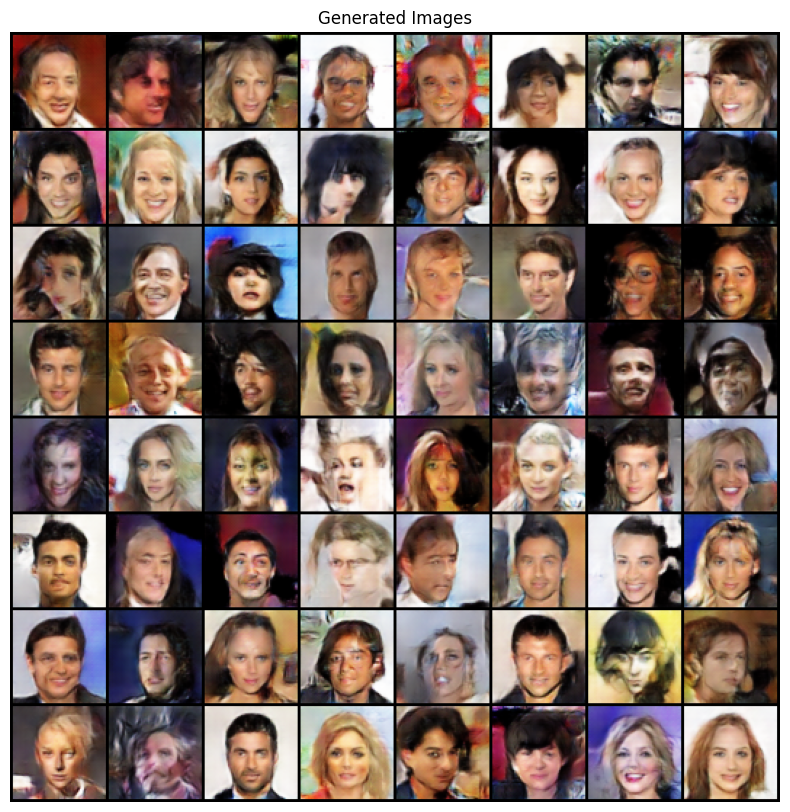

In [ ]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os

# Set random seed for reproducibility
manualSeed = 999
torch.manual_seed(manualSeed)

# Root directory for dataset
dataroot = "celeba/img_align_celeba"  # Adjust path if necessary

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

# Create the dataloader
dataloader = DataLoader(dataset, batch_size=batch_size,
                        shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Weight initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Generator Code
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Create the generator
netG = Generator(ngpu).to(device)

# Apply the weight initialization function
netG.apply(weights_init)

# Discriminator Code
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

# Create the discriminator
netD = Discriminator(ngpu).to(device)

# Apply the weight initialization function
netD.apply(weights_init)

# Loss function
criterion = nn.BCELoss()

# Create batch of latent vectors
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Training Loop

img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):

        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # (2) Update G network: maximize log(D(G(z)))
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 50 == 0:
            print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}] '
                  f'Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} '
                  f'D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

# Plot some generated images
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(fake[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()
